<a href="https://colab.research.google.com/github/zahraDehghanian97/Adversarially-Learned-Anomaly-Detection/blob/master/toy_experiments/ALAD%20-%20toy%20example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ALAD - Toy examples

### Imports

In [2]:
%matplotlib inline
import os
import pdb
import sys
py_file_location = "/content/drive/MyDrive/Colab Notebooks/Adversarially-Learned-Anomaly-Detection/toy_experiments/utils"
sys.path.append(os.path.abspath(py_file_location))

In [3]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from data_gmm import GMM_distribution, sample_GMM, plot_GMM
from data_utils import shuffle, iter_data, ToyDataset
from tqdm import tqdm
import sklearn.datasets

slim = tf.contrib.slim
ds = tf.contrib.distributions
graph_replace = tf.contrib.graph_editor.graph_replace

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Parameters

In [4]:
DATASET = '4gaussians' # 5gaussians, swiss_roll, s_curve
N_NOISY = 100

In [5]:
""" parameters """
n_epoch = 300
batch_size  = 1024
dataset_size_x = 512*4
dataset_size_z = 512*4

dataset_size_x_test = 512*2
dataset_size_z_test = 512*2

input_dim = 2
latent_dim = 2
eps_dim = 2

n_layer_disc  = 2
n_hidden_disc = 256
n_layer_gen   = 3
n_hidden_gen  = 256
n_layer_inf   = 2
n_hidden_inf  = 256

In [6]:
""" Create directory for results """
result_dir = '/content/drive/MyDrive/Colab Notebooks/Adversarially-Learned-Anomaly-Detection/toy_experiments/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

## Training dataset

#### 4 or 5 GMM

In [7]:
""" Create dataset """

def four_five_gaussians(p1=0):
    # create X dataset
    global dataset_size_x
    means_x = map(lambda x:  np.array(x), [[2, 2],[-2, -2],[2, -2],[-2, 2],[0, 0]])
    means_x = list(means_x)
    std_x = 0.02
    variances_x = [np.eye(2) * std_x for _ in means_x]
    #contamination = 4.0*p/(1-p)
    priors_x = np.array([1.0, 1.0, 1.0, 1.0, p1])
    priors_x /= sum(priors_x)
    #print(priors_x)
    gaussian_mixture = GMM_distribution(means=means_x,variances=variances_x,priors=priors_x)
    dataset_x = sample_GMM(dataset_size_x, means_x, variances_x, priors_x, sources=('features', ))
    return dataset_x

You can control the level of the fifth gaussian in the training set with the $p$ parameter

Generate training dataset

In [8]:
dataset_x = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_train.png'


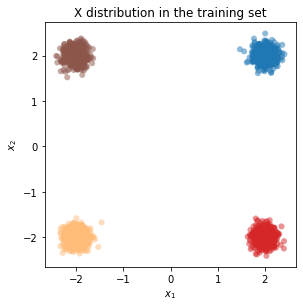

In [9]:
## input x
X_dataset  = dataset_x.data['samples']
X_targets = dataset_x.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_dataset[:, 0], X_dataset[:, 1], c=cm.tab20(X_targets.astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title("X distribution in the training set" )
ax.axis('on')
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

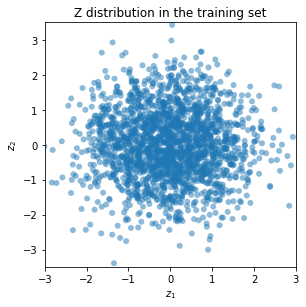

In [10]:
# create Z dataset
means_z = map(lambda x:  np.array(x), [[0, 0]])
means_z = list(means_z)
std_z = 1.0
variances_z = [np.eye(2) * std_z for _ in means_z]
priors_z = [1.0/len(means_z) for _ in means_z]

dataset_z = sample_GMM(dataset_size_z, means_z, variances_z, priors_z, sources=('features', ))
save_path_z = result_dir + 'Z_gmm_data_train.png'

##  input z
Z_dataset = dataset_z.data['samples']
Z_labels  = dataset_z.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_dataset[:, 0], Z_dataset[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.set_title("Z distribution in the training set")
ax.axis('on')
plt.savefig(save_path_z, transparent=True, bbox_inches='tight')
plt.show()

## Network

In [11]:
""" Networks """

def generative_network(z, input_dim, n_layer, n_hidden, eps_dim, reuse=False):
    with tf.variable_scope("generative", reuse=reuse):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, input_dim, activation_fn=None)
    return x


def inference_network(x, latent_dim, n_layer, n_hidden, eps_dim, reuse=False):
    with tf.variable_scope("inference", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        z = slim.fully_connected(h, latent_dim, activation_fn=None)      
    return z

def data_network_xz(x, z, n_layers=2, n_hidden=128, activation_fn=None,reuse=False):
    """Approximate x log data density."""
    h = tf.concat([x,z], 1)
    with tf.variable_scope('discriminator', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return tf.squeeze(log_d, squeeze_dims=[1])

def data_network_xx(x,x_hat, n_layers=1, n_hidden=128, activation_fn=None, reuse=False):
    """Approximate x log data density."""
    # pdb.set_trace()
    h = tf.concat([x,x_hat], 1)
    with tf.variable_scope('discriminator_xx', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

def data_network_zz(z, z_prime, n_layers=1, n_hidden=128, activation_fn=None, reuse=False):
    """Approximate x log data density."""
    # pdb.set_trace()
    h = tf.concat([z, z_prime], 1)
    with tf.variable_scope('discriminator_zz', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

In [12]:
""" Construct model and training ops """
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, input_dim))
z = tf.placeholder(tf.float32, shape=(None, latent_dim))

# decoder and encoder
p_x = generative_network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
q_z = inference_network(x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim)

decoder_logit = data_network_xz(p_x, z, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
encoder_logit = graph_replace(decoder_logit, {p_x: x, z:q_z})

decoder_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(decoder_logit), logits=decoder_logit)
encoder_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(encoder_logit), logits=encoder_logit)

dis_loss_xz = tf.reduce_mean(encoder_loss) + tf.reduce_mean(decoder_loss)

rec_z = inference_network(p_x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim, reuse=True)
rec_x = generative_network(q_z, input_dim , n_layer_gen, n_hidden_gen,  eps_dim, reuse=True)

x_logit_real = data_network_xx(x, x)
x_logit_fake = data_network_xx(x, rec_x, reuse=True)
z_logit_real = data_network_zz(z, z)
z_logit_fake = data_network_zz(z, rec_z,  reuse=True)

x_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.ones_like(x_logit_real))
x_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.zeros_like(x_logit_fake))

z_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.ones_like(z_logit_real))
z_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.zeros_like(z_logit_fake))

x_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.zeros_like(x_logit_real))
x_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.ones_like(x_logit_fake))

z_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.zeros_like(z_logit_real))
z_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.ones_like(z_logit_fake))


dis_loss_x = tf.reduce_mean(x_sigmoid_real + x_sigmoid_fake)
dis_loss_z = tf.reduce_mean(z_sigmoid_real + z_sigmoid_fake)
disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z

cost_x = tf.reduce_mean(x_sigmoid_real2 + x_sigmoid_fake2) # + tf.reduce_mean(tf.pow(x_feature_real - x_feature_fake, 2))
cost_z = tf.reduce_mean(z_sigmoid_real2 + z_sigmoid_fake2) # + tf.reduce_mean(tf.pow(z_feature_real - z_feature_fake, 2))


decoder_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(decoder_logit), logits=decoder_logit)
encoder_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(encoder_logit), logits=encoder_logit)

gen_loss_xz = tf.reduce_mean(decoder_loss2)  + tf.reduce_mean(encoder_loss2)

gen_loss = gen_loss_xz + cost_x  + cost_z

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
dvars_xx = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_xx")
dvars_zz = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_zz")

opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars + dvars_xx)

mahalanobis_dis_z = tf.norm(q_z, ord=2, axis=1, keep_dims=False, name='z_scores')

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Please use tensorflow.python.ops.op_selector.get_backward_walk_ops.
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Training

In [13]:
""" training """
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())


FG = []
FD = []

for epoch in tqdm( range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    i = 0
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):
        i = i + 1
        for _ in range(1):
            f_d, _ = sess.run([disc_loss, train_disc_op], feed_dict={x: xmb, z:zmb})
        for _ in range(5):
            f_g, _ = sess.run([[gen_loss, gen_loss_xz, cost_x], train_gen_op], feed_dict={x: xmb, z:zmb})

        FG.append(f_g)
        FD.append(f_d)

    print("epoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))

  1%|          | 2/300 [00:02<04:36,  1.08it/s]

epoch 0 iter 2: discloss 4.360921 genloss 3.852499 adv_x 1.267812 recons_x 1.242603 
epoch 1 iter 2: discloss 4.339077 genloss 4.189362 adv_x 1.285132 recons_x 1.486473 


  1%|▏         | 4/300 [00:02<01:57,  2.52it/s]

epoch 2 iter 2: discloss 4.298818 genloss 4.152678 adv_x 1.245366 recons_x 1.462894 
epoch 3 iter 2: discloss 4.357712 genloss 4.211171 adv_x 1.342534 recons_x 1.436667 


  2%|▏         | 6/300 [00:02<01:10,  4.17it/s]

epoch 4 iter 2: discloss 4.276402 genloss 4.076283 adv_x 1.219859 recons_x 1.461238 
epoch 5 iter 2: discloss 4.586203 genloss 4.221132 adv_x 1.348731 recons_x 1.439651 


  3%|▎         | 8/300 [00:02<00:51,  5.64it/s]

epoch 6 iter 2: discloss 4.412850 genloss 4.202827 adv_x 1.287678 recons_x 1.508334 
epoch 7 iter 2: discloss 4.268458 genloss 4.387855 adv_x 1.433809 recons_x 1.502986 


  3%|▎         | 10/300 [00:03<00:42,  6.75it/s]

epoch 8 iter 2: discloss 4.061495 genloss 4.247760 adv_x 1.364102 recons_x 1.435975 
epoch 9 iter 2: discloss 4.209802 genloss 4.193703 adv_x 1.395547 recons_x 1.394344 


  4%|▍         | 12/300 [00:03<00:38,  7.48it/s]

epoch 10 iter 2: discloss 4.175179 genloss 4.161811 adv_x 1.348795 recons_x 1.402702 
epoch 11 iter 2: discloss 4.168500 genloss 4.198139 adv_x 1.386497 recons_x 1.401395 


  5%|▍         | 14/300 [00:03<00:36,  7.93it/s]

epoch 12 iter 2: discloss 4.113477 genloss 4.260366 adv_x 1.431594 recons_x 1.411195 
epoch 13 iter 2: discloss 4.117267 genloss 4.200194 adv_x 1.379319 recons_x 1.404628 


  5%|▌         | 16/300 [00:03<00:34,  8.12it/s]

epoch 14 iter 2: discloss 4.141356 genloss 4.197650 adv_x 1.389923 recons_x 1.396334 
epoch 15 iter 2: discloss 4.134652 genloss 4.200902 adv_x 1.390578 recons_x 1.397697 


  6%|▌         | 18/300 [00:04<00:34,  8.08it/s]

epoch 16 iter 2: discloss 4.112612 genloss 4.210823 adv_x 1.395164 recons_x 1.398353 
epoch 17 iter 2: discloss 4.112402 genloss 4.216618 adv_x 1.403763 recons_x 1.397718 


  7%|▋         | 20/300 [00:04<00:33,  8.27it/s]

epoch 18 iter 2: discloss 4.113460 genloss 4.214145 adv_x 1.399572 recons_x 1.390820 
epoch 19 iter 2: discloss 4.111064 genloss 4.221961 adv_x 1.404291 recons_x 1.392798 


  7%|▋         | 22/300 [00:04<00:33,  8.38it/s]

epoch 20 iter 2: discloss 4.100606 genloss 4.231180 adv_x 1.413963 recons_x 1.393013 
epoch 21 iter 2: discloss 4.090879 genloss 4.241296 adv_x 1.419830 recons_x 1.402979 


  8%|▊         | 24/300 [00:04<00:33,  8.18it/s]

epoch 22 iter 2: discloss 4.101964 genloss 4.227157 adv_x 1.396773 recons_x 1.401248 
epoch 23 iter 2: discloss 4.089297 genloss 4.235287 adv_x 1.405462 recons_x 1.402190 


  9%|▊         | 26/300 [00:05<00:33,  8.27it/s]

epoch 24 iter 2: discloss 4.106566 genloss 4.222022 adv_x 1.365153 recons_x 1.430070 
epoch 25 iter 2: discloss 4.084509 genloss 4.208866 adv_x 1.307306 recons_x 1.471684 


  9%|▉         | 28/300 [00:05<00:32,  8.35it/s]

epoch 26 iter 2: discloss 4.090418 genloss 4.229395 adv_x 1.346114 recons_x 1.440453 
epoch 27 iter 2: discloss 4.165475 genloss 4.245622 adv_x 1.347980 recons_x 1.462761 


 10%|█         | 30/300 [00:05<00:32,  8.32it/s]

epoch 28 iter 2: discloss 4.171470 genloss 4.213432 adv_x 1.372911 recons_x 1.398219 
epoch 29 iter 2: discloss 4.145195 genloss 4.213261 adv_x 1.366419 recons_x 1.401572 


 11%|█         | 32/300 [00:05<00:32,  8.23it/s]

epoch 30 iter 2: discloss 4.092419 genloss 4.246573 adv_x 1.407945 recons_x 1.401700 
epoch 31 iter 2: discloss 4.108044 genloss 4.259042 adv_x 1.407650 recons_x 1.412827 


 11%|█▏        | 34/300 [00:06<00:31,  8.34it/s]

epoch 32 iter 2: discloss 4.108524 genloss 4.235044 adv_x 1.395974 recons_x 1.411814 
epoch 33 iter 2: discloss 4.111363 genloss 4.217680 adv_x 1.404661 recons_x 1.395334 


 12%|█▏        | 36/300 [00:06<00:31,  8.28it/s]

epoch 34 iter 2: discloss 4.095973 genloss 4.235487 adv_x 1.408917 recons_x 1.405359 
epoch 35 iter 2: discloss 4.094863 genloss 4.242768 adv_x 1.406740 recons_x 1.410415 


 13%|█▎        | 38/300 [00:06<00:31,  8.27it/s]

epoch 36 iter 2: discloss 4.067122 genloss 4.240580 adv_x 1.415866 recons_x 1.398344 
epoch 37 iter 2: discloss 4.089056 genloss 4.246548 adv_x 1.389004 recons_x 1.426212 


 13%|█▎        | 40/300 [00:06<00:31,  8.15it/s]

epoch 38 iter 2: discloss 4.080595 genloss 4.242115 adv_x 1.402162 recons_x 1.415989 
epoch 39 iter 2: discloss 4.075032 genloss 4.220195 adv_x 1.395308 recons_x 1.401583 


 14%|█▍        | 42/300 [00:07<00:31,  8.19it/s]

epoch 40 iter 2: discloss 4.108748 genloss 4.231864 adv_x 1.397524 recons_x 1.407783 
epoch 41 iter 2: discloss 4.092250 genloss 4.249285 adv_x 1.409730 recons_x 1.405481 


 15%|█▍        | 44/300 [00:07<00:30,  8.29it/s]

epoch 42 iter 2: discloss 4.115280 genloss 4.248510 adv_x 1.394896 recons_x 1.421370 
epoch 43 iter 2: discloss 4.106497 genloss 4.230146 adv_x 1.395349 recons_x 1.414128 


 15%|█▌        | 46/300 [00:07<00:30,  8.22it/s]

epoch 44 iter 2: discloss 4.111518 genloss 4.211614 adv_x 1.379045 recons_x 1.409377 
epoch 45 iter 2: discloss 4.118444 genloss 4.223360 adv_x 1.382408 recons_x 1.405173 


 16%|█▌        | 48/300 [00:07<00:30,  8.36it/s]

epoch 46 iter 2: discloss 4.070269 genloss 4.276756 adv_x 1.411389 recons_x 1.426684 
epoch 47 iter 2: discloss 4.094987 genloss 4.211449 adv_x 1.389621 recons_x 1.405184 


 17%|█▋        | 50/300 [00:08<00:29,  8.39it/s]

epoch 48 iter 2: discloss 4.101476 genloss 4.250973 adv_x 1.391859 recons_x 1.435233 
epoch 49 iter 2: discloss 4.089369 genloss 4.226498 adv_x 1.399409 recons_x 1.402333 


 17%|█▋        | 52/300 [00:08<00:29,  8.43it/s]

epoch 50 iter 2: discloss 4.117120 genloss 4.240459 adv_x 1.407941 recons_x 1.411737 
epoch 51 iter 2: discloss 4.100740 genloss 4.243356 adv_x 1.404954 recons_x 1.410246 


 18%|█▊        | 54/300 [00:08<00:29,  8.37it/s]

epoch 52 iter 2: discloss 4.120276 genloss 4.225338 adv_x 1.411793 recons_x 1.395450 
epoch 53 iter 2: discloss 4.089566 genloss 4.264488 adv_x 1.406511 recons_x 1.418175 


 19%|█▊        | 56/300 [00:08<00:28,  8.45it/s]

epoch 54 iter 2: discloss 4.084303 genloss 4.231827 adv_x 1.424222 recons_x 1.397661 
epoch 55 iter 2: discloss 4.083743 genloss 4.231975 adv_x 1.395717 recons_x 1.410806 


 19%|█▉        | 58/300 [00:08<00:28,  8.36it/s]

epoch 56 iter 2: discloss 4.088157 genloss 4.254004 adv_x 1.414284 recons_x 1.416594 
epoch 57 iter 2: discloss 4.080203 genloss 4.245418 adv_x 1.435968 recons_x 1.393733 


 20%|██        | 60/300 [00:09<00:29,  8.28it/s]

epoch 58 iter 2: discloss 4.093437 genloss 4.240207 adv_x 1.420895 recons_x 1.400405 
epoch 59 iter 2: discloss 4.095315 genloss 4.233440 adv_x 1.404216 recons_x 1.406464 


 21%|██        | 62/300 [00:09<00:28,  8.26it/s]

epoch 60 iter 2: discloss 4.081722 genloss 4.245461 adv_x 1.421834 recons_x 1.403263 
epoch 61 iter 2: discloss 4.114332 genloss 4.225144 adv_x 1.405128 recons_x 1.398768 


 21%|██▏       | 64/300 [00:09<00:28,  8.32it/s]

epoch 62 iter 2: discloss 4.085763 genloss 4.239570 adv_x 1.445632 recons_x 1.385988 
epoch 63 iter 2: discloss 4.082265 genloss 4.232937 adv_x 1.410710 recons_x 1.402152 


 22%|██▏       | 66/300 [00:09<00:28,  8.27it/s]

epoch 64 iter 2: discloss 4.122067 genloss 4.229677 adv_x 1.388058 recons_x 1.411592 
epoch 65 iter 2: discloss 4.113598 genloss 4.267984 adv_x 1.440314 recons_x 1.411040 


 23%|██▎       | 68/300 [00:10<00:27,  8.34it/s]

epoch 66 iter 2: discloss 4.067554 genloss 4.271493 adv_x 1.412788 recons_x 1.426406 
epoch 67 iter 2: discloss 4.078686 genloss 4.227975 adv_x 1.398887 recons_x 1.404924 


 23%|██▎       | 70/300 [00:10<00:27,  8.34it/s]

epoch 68 iter 2: discloss 4.100819 genloss 4.242163 adv_x 1.434351 recons_x 1.389628 
epoch 69 iter 2: discloss 4.083121 genloss 4.223953 adv_x 1.407238 recons_x 1.400334 


 24%|██▍       | 72/300 [00:10<00:27,  8.30it/s]

epoch 70 iter 2: discloss 4.116372 genloss 4.242866 adv_x 1.406668 recons_x 1.415860 
epoch 71 iter 2: discloss 4.078331 genloss 4.244771 adv_x 1.430290 recons_x 1.400269 


 25%|██▍       | 74/300 [00:10<00:27,  8.25it/s]

epoch 72 iter 2: discloss 4.097384 genloss 4.248438 adv_x 1.394938 recons_x 1.414119 
epoch 73 iter 2: discloss 4.081688 genloss 4.262619 adv_x 1.436805 recons_x 1.397980 


 25%|██▌       | 76/300 [00:11<00:26,  8.35it/s]

epoch 74 iter 2: discloss 4.063788 genloss 4.250668 adv_x 1.419014 recons_x 1.404292 
epoch 75 iter 2: discloss 4.076747 genloss 4.235827 adv_x 1.433823 recons_x 1.393303 


 26%|██▌       | 78/300 [00:11<00:26,  8.37it/s]

epoch 76 iter 2: discloss 4.053148 genloss 4.281584 adv_x 1.451524 recons_x 1.403855 
epoch 77 iter 2: discloss 4.078320 genloss 4.253545 adv_x 1.442189 recons_x 1.391373 


 27%|██▋       | 80/300 [00:11<00:26,  8.29it/s]

epoch 78 iter 2: discloss 4.056359 genloss 4.263227 adv_x 1.437045 recons_x 1.397494 
epoch 79 iter 2: discloss 4.070293 genloss 4.259125 adv_x 1.429410 recons_x 1.406271 


 27%|██▋       | 82/300 [00:11<00:26,  8.14it/s]

epoch 80 iter 2: discloss 4.059940 genloss 4.273714 adv_x 1.443287 recons_x 1.397349 
epoch 81 iter 2: discloss 4.072034 genloss 4.261167 adv_x 1.456391 recons_x 1.392467 


 28%|██▊       | 84/300 [00:12<00:26,  8.19it/s]

epoch 82 iter 2: discloss 4.072354 genloss 4.271701 adv_x 1.450416 recons_x 1.400813 
epoch 83 iter 2: discloss 4.034745 genloss 4.260386 adv_x 1.440606 recons_x 1.399961 


 29%|██▊       | 86/300 [00:12<00:25,  8.28it/s]

epoch 84 iter 2: discloss 4.093771 genloss 4.246769 adv_x 1.438958 recons_x 1.393367 
epoch 85 iter 2: discloss 4.054482 genloss 4.309976 adv_x 1.469787 recons_x 1.409320 


 29%|██▉       | 88/300 [00:12<00:25,  8.19it/s]

epoch 86 iter 2: discloss 4.090682 genloss 4.249970 adv_x 1.435611 recons_x 1.394753 
epoch 87 iter 2: discloss 4.051301 genloss 4.302781 adv_x 1.483068 recons_x 1.397748 


 30%|███       | 90/300 [00:12<00:25,  8.32it/s]

epoch 88 iter 2: discloss 4.049559 genloss 4.267286 adv_x 1.448815 recons_x 1.398375 
epoch 89 iter 2: discloss 4.075986 genloss 4.316540 adv_x 1.475430 recons_x 1.408609 


 31%|███       | 92/300 [00:13<00:25,  8.26it/s]

epoch 90 iter 2: discloss 4.026709 genloss 4.306695 adv_x 1.467856 recons_x 1.402778 
epoch 91 iter 2: discloss 4.066531 genloss 4.293521 adv_x 1.470691 recons_x 1.394879 


 31%|███▏      | 94/300 [00:13<00:24,  8.34it/s]

epoch 92 iter 2: discloss 4.037693 genloss 4.315081 adv_x 1.484261 recons_x 1.394599 
epoch 93 iter 2: discloss 4.024318 genloss 4.296244 adv_x 1.477795 recons_x 1.392987 


 32%|███▏      | 96/300 [00:13<00:24,  8.25it/s]

epoch 94 iter 2: discloss 4.050767 genloss 4.319284 adv_x 1.490506 recons_x 1.394723 
epoch 95 iter 2: discloss 3.974064 genloss 4.374433 adv_x 1.504237 recons_x 1.409541 


 33%|███▎      | 98/300 [00:13<00:23,  8.44it/s]

epoch 96 iter 2: discloss 4.027800 genloss 4.318962 adv_x 1.445081 recons_x 1.427111 
epoch 97 iter 2: discloss 4.009602 genloss 4.319974 adv_x 1.474401 recons_x 1.402609 


 33%|███▎      | 100/300 [00:14<00:24,  8.28it/s]

epoch 98 iter 2: discloss 4.032515 genloss 4.402202 adv_x 1.501096 recons_x 1.451014 
epoch 99 iter 2: discloss 3.999890 genloss 4.338114 adv_x 1.468953 recons_x 1.425904 


 34%|███▍      | 102/300 [00:14<00:24,  8.13it/s]

epoch 100 iter 2: discloss 4.079808 genloss 4.297634 adv_x 1.458188 recons_x 1.403783 
epoch 101 iter 2: discloss 4.010154 genloss 4.368549 adv_x 1.521325 recons_x 1.404655 


 35%|███▍      | 104/300 [00:14<00:24,  8.16it/s]

epoch 102 iter 2: discloss 4.027504 genloss 4.314957 adv_x 1.466430 recons_x 1.409448 
epoch 103 iter 2: discloss 4.025528 genloss 4.331801 adv_x 1.485555 recons_x 1.403162 


 35%|███▌      | 106/300 [00:14<00:23,  8.25it/s]

epoch 104 iter 2: discloss 4.031689 genloss 4.356456 adv_x 1.481495 recons_x 1.412552 
epoch 105 iter 2: discloss 4.026999 genloss 4.324375 adv_x 1.494611 recons_x 1.391284 


 36%|███▌      | 108/300 [00:15<00:23,  8.27it/s]

epoch 106 iter 2: discloss 3.985037 genloss 4.338197 adv_x 1.491277 recons_x 1.400140 
epoch 107 iter 2: discloss 4.044623 genloss 4.323504 adv_x 1.475003 recons_x 1.398253 


 37%|███▋      | 110/300 [00:15<00:23,  8.14it/s]

epoch 108 iter 2: discloss 4.040266 genloss 4.388200 adv_x 1.502549 recons_x 1.407578 
epoch 109 iter 2: discloss 4.025794 genloss 4.330818 adv_x 1.443227 recons_x 1.410999 


 37%|███▋      | 112/300 [00:15<00:22,  8.21it/s]

epoch 110 iter 2: discloss 4.048768 genloss 4.309572 adv_x 1.469594 recons_x 1.391757 
epoch 111 iter 2: discloss 4.042781 genloss 4.304385 adv_x 1.445780 recons_x 1.409512 


 38%|███▊      | 114/300 [00:15<00:22,  8.28it/s]

epoch 112 iter 2: discloss 4.033028 genloss 4.382884 adv_x 1.485018 recons_x 1.411137 
epoch 113 iter 2: discloss 4.038385 genloss 4.302305 adv_x 1.450111 recons_x 1.402281 


 39%|███▊      | 116/300 [00:16<00:22,  8.29it/s]

epoch 114 iter 2: discloss 4.061422 genloss 4.309857 adv_x 1.445954 recons_x 1.401487 
epoch 115 iter 2: discloss 4.045014 genloss 4.507157 adv_x 1.435516 recons_x 1.453770 


 39%|███▉      | 118/300 [00:16<00:23,  7.89it/s]

epoch 116 iter 2: discloss 3.918341 genloss 4.405169 adv_x 1.503975 recons_x 1.419212 
epoch 117 iter 2: discloss 4.034318 genloss 4.311882 adv_x 1.453919 recons_x 1.393704 


 40%|████      | 120/300 [00:16<00:22,  8.18it/s]

epoch 118 iter 2: discloss 4.086345 genloss 4.317142 adv_x 1.449371 recons_x 1.408065 
epoch 119 iter 2: discloss 4.050916 genloss 4.339624 adv_x 1.446015 recons_x 1.430470 


 41%|████      | 122/300 [00:16<00:21,  8.16it/s]

epoch 120 iter 2: discloss 4.041424 genloss 4.309835 adv_x 1.468976 recons_x 1.395500 
epoch 121 iter 2: discloss 4.025538 genloss 4.364140 adv_x 1.485217 recons_x 1.397629 


 41%|████▏     | 124/300 [00:17<00:22,  7.93it/s]

epoch 122 iter 2: discloss 4.026534 genloss 4.335202 adv_x 1.470550 recons_x 1.397505 
epoch 123 iter 2: discloss 4.073149 genloss 4.324307 adv_x 1.449446 recons_x 1.408843 


 42%|████▏     | 126/300 [00:17<00:21,  7.98it/s]

epoch 124 iter 2: discloss 4.042525 genloss 4.324031 adv_x 1.474590 recons_x 1.398691 
epoch 125 iter 2: discloss 4.022312 genloss 4.337962 adv_x 1.492758 recons_x 1.395047 


 43%|████▎     | 128/300 [00:17<00:21,  7.99it/s]

epoch 126 iter 2: discloss 4.016481 genloss 4.330916 adv_x 1.476314 recons_x 1.396345 
epoch 127 iter 2: discloss 4.002866 genloss 4.306521 adv_x 1.472084 recons_x 1.387597 


 43%|████▎     | 130/300 [00:17<00:21,  8.07it/s]

epoch 128 iter 2: discloss 4.008294 genloss 4.331682 adv_x 1.432522 recons_x 1.436943 
epoch 129 iter 2: discloss 3.924438 genloss 4.386305 adv_x 1.513404 recons_x 1.394111 


 44%|████▍     | 132/300 [00:18<00:20,  8.10it/s]

epoch 130 iter 2: discloss 3.997787 genloss 4.291691 adv_x 1.421529 recons_x 1.403877 
epoch 131 iter 2: discloss 4.046114 genloss 4.350707 adv_x 1.449205 recons_x 1.419151 


 45%|████▍     | 134/300 [00:18<00:20,  8.19it/s]

epoch 132 iter 2: discloss 4.049103 genloss 4.372542 adv_x 1.464228 recons_x 1.432246 
epoch 133 iter 2: discloss 4.015630 genloss 4.356102 adv_x 1.434315 recons_x 1.410780 


 45%|████▌     | 136/300 [00:18<00:19,  8.26it/s]

epoch 134 iter 2: discloss 3.936587 genloss 4.374067 adv_x 1.458457 recons_x 1.423864 
epoch 135 iter 2: discloss 4.024609 genloss 4.392126 adv_x 1.429501 recons_x 1.475484 


 46%|████▌     | 138/300 [00:18<00:19,  8.21it/s]

epoch 136 iter 2: discloss 3.935544 genloss 4.395780 adv_x 1.511002 recons_x 1.409341 
epoch 137 iter 2: discloss 4.039410 genloss 4.305256 adv_x 1.442930 recons_x 1.398376 


 47%|████▋     | 140/300 [00:18<00:19,  8.16it/s]

epoch 138 iter 2: discloss 3.962825 genloss 4.394139 adv_x 1.527349 recons_x 1.404768 
epoch 139 iter 2: discloss 3.887352 genloss 4.392027 adv_x 1.497174 recons_x 1.401638 


 47%|████▋     | 142/300 [00:19<00:19,  8.08it/s]

epoch 140 iter 2: discloss 3.995379 genloss 4.295680 adv_x 1.431508 recons_x 1.391670 
epoch 141 iter 2: discloss 4.006580 genloss 4.493851 adv_x 1.574642 recons_x 1.406107 


 48%|████▊     | 144/300 [00:19<00:19,  8.20it/s]

epoch 142 iter 2: discloss 3.987934 genloss 4.305179 adv_x 1.404415 recons_x 1.400045 
epoch 143 iter 2: discloss 3.985033 genloss 4.339701 adv_x 1.463197 recons_x 1.397030 


 49%|████▊     | 146/300 [00:19<00:19,  7.99it/s]

epoch 144 iter 2: discloss 4.043013 genloss 4.354955 adv_x 1.464930 recons_x 1.406709 
epoch 145 iter 2: discloss 4.066522 genloss 4.300514 adv_x 1.424653 recons_x 1.404007 


 49%|████▉     | 148/300 [00:19<00:18,  8.03it/s]

epoch 146 iter 2: discloss 4.036695 genloss 4.389019 adv_x 1.549120 recons_x 1.392905 
epoch 147 iter 2: discloss 3.984972 genloss 4.417950 adv_x 1.465950 recons_x 1.426053 


 50%|█████     | 150/300 [00:20<00:18,  8.12it/s]

epoch 148 iter 2: discloss 4.023151 genloss 4.302646 adv_x 1.439065 recons_x 1.388651 
epoch 149 iter 2: discloss 3.987775 genloss 4.387486 adv_x 1.478076 recons_x 1.405458 


 51%|█████     | 152/300 [00:20<00:18,  8.19it/s]

epoch 150 iter 2: discloss 4.039475 genloss 4.302696 adv_x 1.410917 recons_x 1.403797 
epoch 151 iter 2: discloss 4.092919 genloss 4.361665 adv_x 1.491620 recons_x 1.394736 


 51%|█████▏    | 154/300 [00:20<00:17,  8.24it/s]

epoch 152 iter 2: discloss 3.974178 genloss 4.377263 adv_x 1.491298 recons_x 1.413297 
epoch 153 iter 2: discloss 4.004365 genloss 4.328703 adv_x 1.466045 recons_x 1.403252 


 52%|█████▏    | 156/300 [00:20<00:17,  8.08it/s]

epoch 154 iter 2: discloss 4.037202 genloss 4.327312 adv_x 1.455741 recons_x 1.398692 
epoch 155 iter 2: discloss 4.028571 genloss 4.320530 adv_x 1.446398 recons_x 1.402306 


 53%|█████▎    | 158/300 [00:21<00:17,  8.18it/s]

epoch 156 iter 2: discloss 4.003132 genloss 4.400754 adv_x 1.515557 recons_x 1.400289 
epoch 157 iter 2: discloss 4.003203 genloss 4.299848 adv_x 1.456880 recons_x 1.393323 


 53%|█████▎    | 160/300 [00:21<00:17,  8.23it/s]

epoch 158 iter 2: discloss 3.993051 genloss 4.380988 adv_x 1.478427 recons_x 1.401596 
epoch 159 iter 2: discloss 4.025100 genloss 4.365022 adv_x 1.489951 recons_x 1.392904 


 54%|█████▍    | 162/300 [00:21<00:16,  8.28it/s]

epoch 160 iter 2: discloss 3.976231 genloss 4.388283 adv_x 1.504642 recons_x 1.400421 
epoch 161 iter 2: discloss 3.973224 genloss 4.410971 adv_x 1.515628 recons_x 1.402387 


 55%|█████▍    | 164/300 [00:21<00:16,  8.13it/s]

epoch 162 iter 2: discloss 4.050827 genloss 4.393496 adv_x 1.487835 recons_x 1.409493 
epoch 163 iter 2: discloss 3.980029 genloss 4.328547 adv_x 1.455314 recons_x 1.408423 


 55%|█████▌    | 166/300 [00:22<00:16,  8.08it/s]

epoch 164 iter 2: discloss 4.021752 genloss 4.354547 adv_x 1.399632 recons_x 1.434151 
epoch 165 iter 2: discloss 4.080320 genloss 4.349400 adv_x 1.443917 recons_x 1.398920 


 56%|█████▌    | 168/300 [00:22<00:16,  8.18it/s]

epoch 166 iter 2: discloss 3.986422 genloss 4.366698 adv_x 1.505697 recons_x 1.391548 
epoch 167 iter 2: discloss 4.003420 genloss 4.369679 adv_x 1.501525 recons_x 1.388435 


 57%|█████▋    | 170/300 [00:22<00:15,  8.26it/s]

epoch 168 iter 2: discloss 4.012471 genloss 4.436955 adv_x 1.529665 recons_x 1.405925 
epoch 169 iter 2: discloss 3.895853 genloss 4.430418 adv_x 1.559527 recons_x 1.394233 


 57%|█████▋    | 172/300 [00:22<00:16,  7.97it/s]

epoch 170 iter 2: discloss 3.860002 genloss 4.395935 adv_x 1.447203 recons_x 1.410429 
epoch 171 iter 2: discloss 4.095463 genloss 4.443120 adv_x 1.418150 recons_x 1.424976 


 58%|█████▊    | 174/300 [00:23<00:15,  7.94it/s]

epoch 172 iter 2: discloss 4.024031 genloss 4.384642 adv_x 1.520477 recons_x 1.385507 
epoch 173 iter 2: discloss 4.026769 genloss 4.410781 adv_x 1.444030 recons_x 1.436770 


 59%|█████▊    | 176/300 [00:23<00:15,  8.19it/s]

epoch 174 iter 2: discloss 3.989901 genloss 4.360404 adv_x 1.480324 recons_x 1.394823 
epoch 175 iter 2: discloss 4.001619 genloss 4.348862 adv_x 1.448786 recons_x 1.404235 


 59%|█████▉    | 178/300 [00:23<00:15,  8.07it/s]

epoch 176 iter 2: discloss 4.016862 genloss 4.398690 adv_x 1.461132 recons_x 1.404080 
epoch 177 iter 2: discloss 4.035759 genloss 4.424189 adv_x 1.453249 recons_x 1.417178 


 60%|██████    | 180/300 [00:23<00:14,  8.09it/s]

epoch 178 iter 2: discloss 3.995727 genloss 4.366750 adv_x 1.487155 recons_x 1.407297 
epoch 179 iter 2: discloss 4.012332 genloss 4.353400 adv_x 1.433579 recons_x 1.410732 


 61%|██████    | 182/300 [00:24<00:14,  7.92it/s]

epoch 180 iter 2: discloss 3.953172 genloss 4.369545 adv_x 1.514986 recons_x 1.392961 
epoch 181 iter 2: discloss 4.010872 genloss 4.399828 adv_x 1.533874 recons_x 1.393896 


 61%|██████▏   | 184/300 [00:24<00:14,  8.05it/s]

epoch 182 iter 2: discloss 3.998042 genloss 4.398236 adv_x 1.487524 recons_x 1.403656 
epoch 183 iter 2: discloss 4.027815 genloss 4.340506 adv_x 1.474571 recons_x 1.390369 


 62%|██████▏   | 186/300 [00:24<00:14,  8.05it/s]

epoch 184 iter 2: discloss 3.979035 genloss 4.414875 adv_x 1.498606 recons_x 1.391562 
epoch 185 iter 2: discloss 3.952610 genloss 4.442934 adv_x 1.508431 recons_x 1.411640 


 63%|██████▎   | 188/300 [00:24<00:13,  8.09it/s]

epoch 186 iter 2: discloss 3.935572 genloss 4.528003 adv_x 1.479947 recons_x 1.470214 
epoch 187 iter 2: discloss 4.033194 genloss 4.337074 adv_x 1.411695 recons_x 1.409238 


 63%|██████▎   | 190/300 [00:25<00:13,  8.19it/s]

epoch 188 iter 2: discloss 3.984498 genloss 4.351972 adv_x 1.481883 recons_x 1.396246 
epoch 189 iter 2: discloss 3.999496 genloss 4.405612 adv_x 1.484340 recons_x 1.406393 


 64%|██████▍   | 192/300 [00:25<00:13,  8.12it/s]

epoch 190 iter 2: discloss 3.968487 genloss 4.417208 adv_x 1.518670 recons_x 1.389221 
epoch 191 iter 2: discloss 3.960407 genloss 4.467905 adv_x 1.523371 recons_x 1.399950 


 65%|██████▍   | 194/300 [00:25<00:12,  8.31it/s]

epoch 192 iter 2: discloss 3.955050 genloss 4.441075 adv_x 1.509398 recons_x 1.398387 
epoch 193 iter 2: discloss 3.948181 genloss 4.458655 adv_x 1.513609 recons_x 1.396666 


 65%|██████▌   | 196/300 [00:25<00:12,  8.21it/s]

epoch 194 iter 2: discloss 4.036886 genloss 4.406615 adv_x 1.465914 recons_x 1.406800 
epoch 195 iter 2: discloss 4.026818 genloss 4.426571 adv_x 1.463778 recons_x 1.398641 


 66%|██████▌   | 198/300 [00:26<00:12,  8.27it/s]

epoch 196 iter 2: discloss 3.993391 genloss 4.438685 adv_x 1.520719 recons_x 1.404031 
epoch 197 iter 2: discloss 3.895300 genloss 4.452065 adv_x 1.580637 recons_x 1.396741 


 67%|██████▋   | 200/300 [00:26<00:12,  8.19it/s]

epoch 198 iter 2: discloss 3.996089 genloss 4.370830 adv_x 1.392006 recons_x 1.442050 
epoch 199 iter 2: discloss 4.056658 genloss 4.332352 adv_x 1.432410 recons_x 1.405905 


 67%|██████▋   | 202/300 [00:26<00:11,  8.22it/s]

epoch 200 iter 2: discloss 3.972953 genloss 4.454782 adv_x 1.517742 recons_x 1.402272 
epoch 201 iter 2: discloss 3.953397 genloss 4.468899 adv_x 1.522382 recons_x 1.400951 


 68%|██████▊   | 204/300 [00:26<00:11,  8.18it/s]

epoch 202 iter 2: discloss 3.967003 genloss 4.428545 adv_x 1.430921 recons_x 1.420466 
epoch 203 iter 2: discloss 4.068559 genloss 4.428219 adv_x 1.438329 recons_x 1.404433 


 69%|██████▊   | 206/300 [00:27<00:11,  8.24it/s]

epoch 204 iter 2: discloss 4.000705 genloss 4.451137 adv_x 1.525211 recons_x 1.397987 
epoch 205 iter 2: discloss 3.971542 genloss 4.411502 adv_x 1.514187 recons_x 1.397522 


 69%|██████▉   | 208/300 [00:27<00:11,  8.19it/s]

epoch 206 iter 2: discloss 4.008973 genloss 4.394015 adv_x 1.480935 recons_x 1.401996 
epoch 207 iter 2: discloss 3.955448 genloss 4.405778 adv_x 1.529842 recons_x 1.400445 


 70%|███████   | 210/300 [00:27<00:10,  8.30it/s]

epoch 208 iter 2: discloss 4.048554 genloss 4.331830 adv_x 1.454635 recons_x 1.390138 
epoch 209 iter 2: discloss 3.956755 genloss 4.463869 adv_x 1.525128 recons_x 1.406356 


 71%|███████   | 212/300 [00:27<00:10,  8.22it/s]

epoch 210 iter 2: discloss 3.979156 genloss 4.435096 adv_x 1.496128 recons_x 1.397454 
epoch 211 iter 2: discloss 4.041461 genloss 4.353208 adv_x 1.418715 recons_x 1.393862 


 71%|███████▏  | 214/300 [00:28<00:10,  8.18it/s]

epoch 212 iter 2: discloss 4.065313 genloss 4.411312 adv_x 1.510599 recons_x 1.399364 
epoch 213 iter 2: discloss 3.959297 genloss 4.452786 adv_x 1.489398 recons_x 1.407338 


 72%|███████▏  | 216/300 [00:28<00:10,  8.15it/s]

epoch 214 iter 2: discloss 3.988806 genloss 4.352690 adv_x 1.440150 recons_x 1.399101 
epoch 215 iter 2: discloss 4.029868 genloss 4.332088 adv_x 1.451160 recons_x 1.383685 


 73%|███████▎  | 218/300 [00:28<00:10,  8.16it/s]

epoch 216 iter 2: discloss 4.051934 genloss 4.337165 adv_x 1.437630 recons_x 1.387397 
epoch 217 iter 2: discloss 3.975405 genloss 4.461203 adv_x 1.532653 recons_x 1.396602 


 73%|███████▎  | 220/300 [00:28<00:09,  8.13it/s]

epoch 218 iter 2: discloss 3.913754 genloss 4.490233 adv_x 1.555904 recons_x 1.398955 
epoch 219 iter 2: discloss 3.977580 genloss 4.351326 adv_x 1.470140 recons_x 1.394423 


 74%|███████▍  | 222/300 [00:29<00:09,  8.18it/s]

epoch 220 iter 2: discloss 4.042624 genloss 4.366293 adv_x 1.440718 recons_x 1.396210 
epoch 221 iter 2: discloss 3.998439 genloss 4.395445 adv_x 1.482167 recons_x 1.395687 


 75%|███████▍  | 224/300 [00:29<00:09,  8.29it/s]

epoch 222 iter 2: discloss 4.006372 genloss 4.404775 adv_x 1.457267 recons_x 1.405497 
epoch 223 iter 2: discloss 3.971084 genloss 4.434514 adv_x 1.524719 recons_x 1.394131 


 75%|███████▌  | 226/300 [00:29<00:08,  8.25it/s]

epoch 224 iter 2: discloss 3.920434 genloss 4.407229 adv_x 1.522615 recons_x 1.390291 
epoch 225 iter 2: discloss 3.946675 genloss 4.390655 adv_x 1.492859 recons_x 1.392653 


 76%|███████▌  | 228/300 [00:29<00:08,  8.16it/s]

epoch 226 iter 2: discloss 4.020001 genloss 4.377272 adv_x 1.476272 recons_x 1.392634 
epoch 227 iter 2: discloss 3.963643 genloss 4.366458 adv_x 1.468853 recons_x 1.391943 


 77%|███████▋  | 230/300 [00:30<00:09,  7.78it/s]

epoch 228 iter 2: discloss 4.002505 genloss 4.474695 adv_x 1.495538 recons_x 1.401029 
epoch 229 iter 2: discloss 3.985072 genloss 4.461262 adv_x 1.507912 recons_x 1.390696 


 77%|███████▋  | 232/300 [00:30<00:08,  7.73it/s]

epoch 230 iter 2: discloss 3.983864 genloss 4.441702 adv_x 1.512636 recons_x 1.396529 
epoch 231 iter 2: discloss 3.922584 genloss 4.412418 adv_x 1.500588 recons_x 1.393124 


 78%|███████▊  | 234/300 [00:30<00:08,  7.97it/s]

epoch 232 iter 2: discloss 3.938905 genloss 4.399230 adv_x 1.402113 recons_x 1.396357 
epoch 233 iter 2: discloss 3.937768 genloss 4.430207 adv_x 1.528710 recons_x 1.396404 


 79%|███████▊  | 236/300 [00:30<00:07,  8.06it/s]

epoch 234 iter 2: discloss 3.973544 genloss 4.421680 adv_x 1.473157 recons_x 1.389300 
epoch 235 iter 2: discloss 3.985897 genloss 4.435560 adv_x 1.518151 recons_x 1.392492 


 79%|███████▉  | 238/300 [00:31<00:07,  8.14it/s]

epoch 236 iter 2: discloss 3.936224 genloss 4.448688 adv_x 1.485536 recons_x 1.408594 
epoch 237 iter 2: discloss 4.074973 genloss 4.337559 adv_x 1.398014 recons_x 1.407664 


 80%|████████  | 240/300 [00:31<00:07,  8.06it/s]

epoch 238 iter 2: discloss 4.060364 genloss 4.441179 adv_x 1.502803 recons_x 1.396075 
epoch 239 iter 2: discloss 3.972107 genloss 4.427708 adv_x 1.469262 recons_x 1.391388 


 81%|████████  | 242/300 [00:31<00:07,  8.16it/s]

epoch 240 iter 2: discloss 3.991918 genloss 4.451955 adv_x 1.512300 recons_x 1.390630 
epoch 241 iter 2: discloss 3.933506 genloss 4.473059 adv_x 1.516763 recons_x 1.393932 


 81%|████████▏ | 244/300 [00:31<00:06,  8.01it/s]

epoch 242 iter 2: discloss 3.980655 genloss 4.444127 adv_x 1.410343 recons_x 1.430329 
epoch 243 iter 2: discloss 4.040997 genloss 4.394602 adv_x 1.440995 recons_x 1.390766 


 82%|████████▏ | 246/300 [00:32<00:06,  8.00it/s]

epoch 244 iter 2: discloss 3.959947 genloss 4.431220 adv_x 1.480708 recons_x 1.402164 
epoch 245 iter 2: discloss 3.908881 genloss 4.405391 adv_x 1.478123 recons_x 1.394956 


 83%|████████▎ | 248/300 [00:32<00:06,  7.95it/s]

epoch 246 iter 2: discloss 4.016675 genloss 4.413179 adv_x 1.521448 recons_x 1.396941 
epoch 247 iter 2: discloss 3.904018 genloss 4.485764 adv_x 1.560775 recons_x 1.401612 


 83%|████████▎ | 250/300 [00:32<00:06,  8.13it/s]

epoch 248 iter 2: discloss 3.958319 genloss 4.451854 adv_x 1.436133 recons_x 1.403682 
epoch 249 iter 2: discloss 3.945482 genloss 4.447153 adv_x 1.407985 recons_x 1.418539 


 84%|████████▍ | 252/300 [00:32<00:05,  8.19it/s]

epoch 250 iter 2: discloss 3.968791 genloss 4.436564 adv_x 1.515952 recons_x 1.390696 
epoch 251 iter 2: discloss 3.962157 genloss 4.462527 adv_x 1.493073 recons_x 1.392593 


 85%|████████▍ | 254/300 [00:33<00:05,  8.29it/s]

epoch 252 iter 2: discloss 4.002821 genloss 4.449935 adv_x 1.468688 recons_x 1.392318 
epoch 253 iter 2: discloss 3.954545 genloss 4.453484 adv_x 1.520651 recons_x 1.396035 


 85%|████████▌ | 256/300 [00:33<00:05,  8.24it/s]

epoch 254 iter 2: discloss 3.971713 genloss 4.481364 adv_x 1.518306 recons_x 1.394698 
epoch 255 iter 2: discloss 3.951918 genloss 4.400493 adv_x 1.484592 recons_x 1.394372 


 86%|████████▌ | 258/300 [00:33<00:05,  8.22it/s]

epoch 256 iter 2: discloss 3.910426 genloss 4.421127 adv_x 1.476967 recons_x 1.397843 
epoch 257 iter 2: discloss 3.970285 genloss 4.441741 adv_x 1.509183 recons_x 1.391005 


 87%|████████▋ | 260/300 [00:33<00:04,  8.10it/s]

epoch 258 iter 2: discloss 3.941969 genloss 4.466840 adv_x 1.538285 recons_x 1.390475 
epoch 259 iter 2: discloss 3.970697 genloss 4.409073 adv_x 1.500319 recons_x 1.392207 


 87%|████████▋ | 262/300 [00:34<00:04,  8.09it/s]

epoch 260 iter 2: discloss 3.999552 genloss 4.450407 adv_x 1.513916 recons_x 1.401405 
epoch 261 iter 2: discloss 3.926177 genloss 4.468490 adv_x 1.546424 recons_x 1.396884 


 88%|████████▊ | 264/300 [00:34<00:04,  8.18it/s]

epoch 262 iter 2: discloss 3.940731 genloss 4.531490 adv_x 1.530276 recons_x 1.401476 
epoch 263 iter 2: discloss 3.949286 genloss 4.439669 adv_x 1.479917 recons_x 1.392652 


 89%|████████▊ | 266/300 [00:34<00:04,  8.22it/s]

epoch 264 iter 2: discloss 3.867900 genloss 4.505201 adv_x 1.518918 recons_x 1.393285 
epoch 265 iter 2: discloss 3.883632 genloss 4.506179 adv_x 1.545131 recons_x 1.391631 


 89%|████████▉ | 268/300 [00:34<00:03,  8.13it/s]

epoch 266 iter 2: discloss 3.930007 genloss 4.535474 adv_x 1.550858 recons_x 1.390945 
epoch 267 iter 2: discloss 3.886279 genloss 4.506646 adv_x 1.520247 recons_x 1.392292 


 90%|█████████ | 270/300 [00:35<00:03,  8.23it/s]

epoch 268 iter 2: discloss 4.002056 genloss 4.446640 adv_x 1.493975 recons_x 1.389464 
epoch 269 iter 2: discloss 3.983105 genloss 4.477912 adv_x 1.509395 recons_x 1.397593 


 91%|█████████ | 272/300 [00:35<00:03,  8.22it/s]

epoch 270 iter 2: discloss 3.978684 genloss 4.480475 adv_x 1.537380 recons_x 1.391149 
epoch 271 iter 2: discloss 3.889887 genloss 4.543511 adv_x 1.591576 recons_x 1.391135 


 91%|█████████▏| 274/300 [00:35<00:03,  7.99it/s]

epoch 272 iter 2: discloss 3.958498 genloss 4.431185 adv_x 1.458868 recons_x 1.392588 
epoch 273 iter 2: discloss 4.056578 genloss 4.476357 adv_x 1.480046 recons_x 1.387502 


 92%|█████████▏| 276/300 [00:35<00:02,  8.04it/s]

epoch 274 iter 2: discloss 3.902178 genloss 4.454818 adv_x 1.559374 recons_x 1.388519 
epoch 275 iter 2: discloss 3.918539 genloss 4.557464 adv_x 1.575523 recons_x 1.391200 


 93%|█████████▎| 278/300 [00:36<00:02,  8.09it/s]

epoch 276 iter 2: discloss 3.988653 genloss 4.528806 adv_x 1.473408 recons_x 1.397712 
epoch 277 iter 2: discloss 3.901633 genloss 4.462599 adv_x 1.580050 recons_x 1.390521 


 93%|█████████▎| 280/300 [00:36<00:02,  7.99it/s]

epoch 278 iter 2: discloss 4.005598 genloss 4.564448 adv_x 1.469409 recons_x 1.435503 
epoch 279 iter 2: discloss 3.993893 genloss 4.441509 adv_x 1.470978 recons_x 1.397607 


 94%|█████████▍| 282/300 [00:36<00:02,  8.04it/s]

epoch 280 iter 2: discloss 3.955529 genloss 4.478083 adv_x 1.522581 recons_x 1.394969 
epoch 281 iter 2: discloss 3.995107 genloss 4.538755 adv_x 1.556301 recons_x 1.392435 


 95%|█████████▍| 284/300 [00:36<00:01,  8.08it/s]

epoch 282 iter 2: discloss 3.963034 genloss 4.397189 adv_x 1.475303 recons_x 1.391349 
epoch 283 iter 2: discloss 3.942808 genloss 4.490574 adv_x 1.547870 recons_x 1.395669 


 95%|█████████▌| 286/300 [00:37<00:01,  7.92it/s]

epoch 284 iter 2: discloss 3.946348 genloss 4.497248 adv_x 1.558239 recons_x 1.390956 
epoch 285 iter 2: discloss 3.952328 genloss 4.388435 adv_x 1.464881 recons_x 1.395536 


 96%|█████████▌| 288/300 [00:37<00:01,  7.85it/s]

epoch 286 iter 2: discloss 4.077272 genloss 4.522871 adv_x 1.501091 recons_x 1.396969 
epoch 287 iter 2: discloss 3.997630 genloss 4.553037 adv_x 1.511441 recons_x 1.397514 


 97%|█████████▋| 290/300 [00:37<00:01,  7.94it/s]

epoch 288 iter 2: discloss 4.022597 genloss 4.421259 adv_x 1.460275 recons_x 1.393445 
epoch 289 iter 2: discloss 3.987004 genloss 4.486565 adv_x 1.496710 recons_x 1.391594 


 97%|█████████▋| 292/300 [00:37<00:01,  7.94it/s]

epoch 290 iter 2: discloss 3.927658 genloss 4.476611 adv_x 1.540309 recons_x 1.396841 
epoch 291 iter 2: discloss 3.854713 genloss 4.537989 adv_x 1.519488 recons_x 1.402015 


 98%|█████████▊| 294/300 [00:38<00:00,  8.05it/s]

epoch 292 iter 2: discloss 3.952769 genloss 4.458446 adv_x 1.454913 recons_x 1.406636 
epoch 293 iter 2: discloss 3.950667 genloss 4.454146 adv_x 1.477581 recons_x 1.404533 


 99%|█████████▊| 296/300 [00:38<00:00,  8.17it/s]

epoch 294 iter 2: discloss 3.929517 genloss 4.516155 adv_x 1.527042 recons_x 1.401947 
epoch 295 iter 2: discloss 3.902629 genloss 4.487477 adv_x 1.537452 recons_x 1.399823 


 99%|█████████▉| 298/300 [00:38<00:00,  8.01it/s]

epoch 296 iter 2: discloss 3.985030 genloss 4.440230 adv_x 1.500876 recons_x 1.398620 
epoch 297 iter 2: discloss 3.889016 genloss 4.524006 adv_x 1.571726 recons_x 1.396653 


100%|██████████| 300/300 [00:38<00:00,  7.74it/s]

epoch 298 iter 2: discloss 3.822608 genloss 4.535264 adv_x 1.540492 recons_x 1.400677 
epoch 299 iter 2: discloss 3.962325 genloss 4.421268 adv_x 1.480752 recons_x 1.395926 


## Test dataset

In [14]:
datasetX_test = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_test.png'

In [15]:
# create X dataset

X_np_data_test = datasetX_test.data['samples']
X_targets_test = datasetX_test.data['label']

In [16]:

X_np_outliers = np.random.uniform(low=X_np_data_test.min(), high=X_np_data_test.max(), size=(N_NOISY,2))#outlier testing size 20\n"
X_outliers_target = [15]* X_np_outliers.shape[0]
X_np_data_test = np.concatenate([X_np_data_test, X_np_outliers], axis=0)
X_targets_test = np.concatenate([X_targets_test, X_outliers_target], axis=0)

Selecting inliers and outliers

In [34]:
idx_inliers = X_targets_test <4 
idx_outliers = np.logical_not(idx_inliers)

Plotting final (cleaned) test dataset

<Figure size 432x288 with 0 Axes>

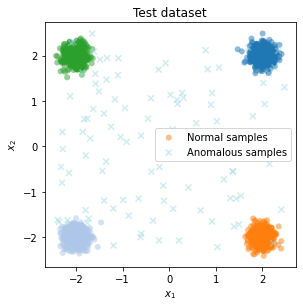

In [18]:
plt.clf()
fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/15.0),
           edgecolor='none', alpha=0.5, label="Normal samples")

ax.scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/15),
       edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')

ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Test dataset")
ax.legend()
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

#### Z Test dataset

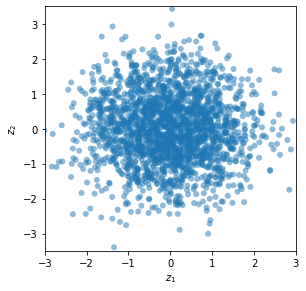

In [19]:
# create Z dataset

datasetZ_test = sample_GMM(X_np_data_test.shape[0], means_z, variances_z, priors_z, sources=('features', ))
save_path = result_dir + 'Z_gmm_data_test.png'
# plot_GMM(dataset, save_path)

Z_np_data_test = datasetZ_test.data['samples']
Z_targets_test = datasetZ_test.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_np_data_test[:, 0], Z_np_data_test[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

### Testing

In [20]:
feed_dict = {x: X_np_data_test, z:Z_np_data_test}
imz = sess.run(q_z, feed_dict=feed_dict)
rmz = sess.run(rec_z, feed_dict=feed_dict)
imx = sess.run(p_x, feed_dict=feed_dict)
rmx = sess.run(rec_x, feed_dict=feed_dict)

score_dz = sess.run(mahalanobis_dis_z, feed_dict=feed_dict)
score_dxx = sess.run(x_sigmoid_real + x_sigmoid_fake, feed_dict=feed_dict)

score = score_dz #+ score_dxx
score = np.linalg.norm(imz, ord=2, axis=1, keepdims=False)
print(score)


[1.0149899  1.0247126  1.4028232  ... 0.9968598  0.45937186 2.0278165 ]


kernel estimation

In [21]:
from sklearn.neighbors import KernelDensity
import numpy as np
feed_dict_train = {x: X_dataset, z:Z_dataset}
imz_train = sess.run(q_z, feed_dict=feed_dict_train)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(imz_train)
score_kernel_train = kde.score_samples(imz_train)
score_kernel=kde.score_samples(imz)
print(score_kernel)

[-1.7670052  -1.77740121 -2.35635642 ... -1.89993148 -1.97278508
 -4.17756361]


hand written digit

In [22]:
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.datasets import load_digits
# from sklearn.neighbors import KernelDensity
# from sklearn.decomposition import PCA
# from sklearn.model_selection import GridSearchCV

# # load the data
# digits = load_digits()

# # project the 64-dimensional data to a lower dimension
# pca = PCA(n_components=15, whiten=False)
# data = pca.fit_transform(digits.data)

# # use grid search cross-validation to optimize the bandwidth
# params = {"bandwidth": np.logspace(-1, 1, 20)}
# grid = GridSearchCV(KernelDensity(), params)
# grid.fit(data)

# print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# # use the best estimator to compute the kernel density estimate
# kde = grid.best_estimator_

# # sample 44 new points from the data
# new_data = kde.sample(44, random_state=0)
# new_data = pca.inverse_transform(new_data)

# # turn data into a 4x11 grid
# new_data = new_data.reshape((4, 11, -1))
# real_data = digits.data[:44].reshape((4, 11, -1))

# # plot real digits and resampled digits
# fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
# for j in range(11):
#     ax[4, j].set_visible(False)
#     for i in range(4):
#         im = ax[i, j].imshow(
#             real_data[i, j].reshape((8, 8)), cmap=plt.cm.binary, interpolation="nearest"
#         )
#         im.set_clim(0, 16)
#         im = ax[i + 5, j].imshow(
#             new_data[i, j].reshape((8, 8)), cmap=plt.cm.binary, interpolation="nearest"
#         )
#         im.set_clim(0, 16)

# ax[0, 5].set_title("Selection from the input data")
# ax[5, 5].set_title('"New" digits drawn from the kernel density model')

# plt.show()

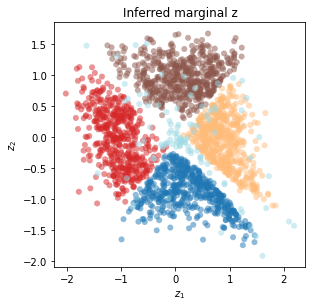

In [23]:
## inferred marginal z
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = X_targets_test
ax.scatter(imz[:, 0], imz[:, 1], c=cm.tab20(ll.astype(float)/input_dim/3.0),
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title("Inferred marginal z")
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

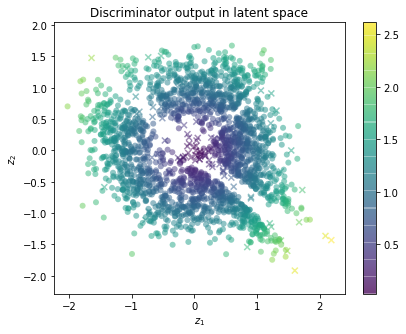

In [35]:
import matplotlib as mpl
## discriminator z choice on latent - v3
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

colors = score#_kernel#zmar(score)
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))

im = ax.scatter(imz[idx_inliers, 0], imz[idx_inliers, 1], c=colors[idx_inliers],
        edgecolor='none', alpha=0.5, label="Normal samples", marker='o', norm=norm)

im = ax.scatter(imz[idx_outliers, 0], imz[idx_outliers, 1], c=colors[idx_outliers],
        edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x', norm=norm)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
fig_mz.colorbar(im)
ax.axis('on')
plt.axis('equal')
ax.set_title("Discriminator output in latent space")
plt.savefig(result_dir + 'inferred_{}_mz_disc.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

real outlier

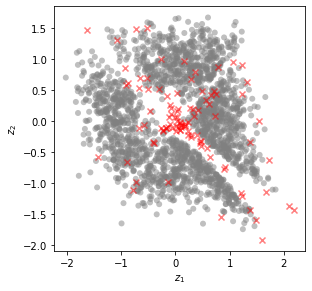

In [51]:
## discriminator z choice on latent - v2
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(imz[idx_inliers][:, 0], imz[idx_inliers][:, 1], c='grey',
        edgecolor='none', alpha=0.5)
ax.scatter(imz[idx_outliers][:, 0], imz[idx_outliers][:, 1], c='r',
        edgecolor='none', alpha=0.5, marker='x')
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

kernel predicted outlier

In [61]:
idx_inliers_predict = score_kernel >4*np.mean(score_kernel_train) / 3 
idx_outliers_predict = np.logical_not(idx_inliers_predict)

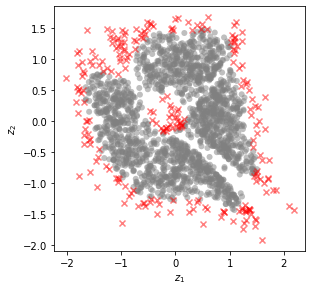

In [62]:
## discriminator z choice on latent - v2
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(imz[idx_inliers_predict][:, 0], imz[idx_inliers_predict][:, 1], c='grey',
        edgecolor='none', alpha=0.5)
ax.scatter(imz[idx_outliers_predict][:, 0], imz[idx_outliers_predict][:, 1], c='r',
        edgecolor='none', alpha=0.5, marker='x')
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

Confusion Matrix kernel

In [55]:
from sklearn.metrics import confusion_matrix
predicted_label = idx_inliers_predict.astype(int)
real_label = idx_inliers.astype(int)
confusion = confusion_matrix(real_label,predicted_label)
print((confusion))


[[  45   55]
 [ 186 1862]]


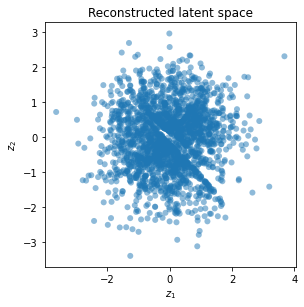

In [27]:
##  reconstructed z
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(rmz[:, 0], rmz[:, 1],
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title('Reconstructed latent space')
plt.savefig(result_dir + 'reconstruct_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

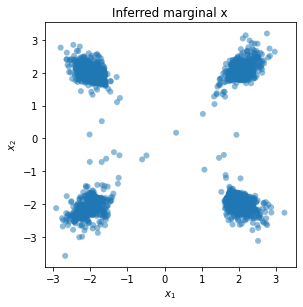

In [28]:
## inferred marginal x
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(imx[:, 0], imx[:, 1],
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Inferred marginal x")
plt.savefig(result_dir + 'inferred_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

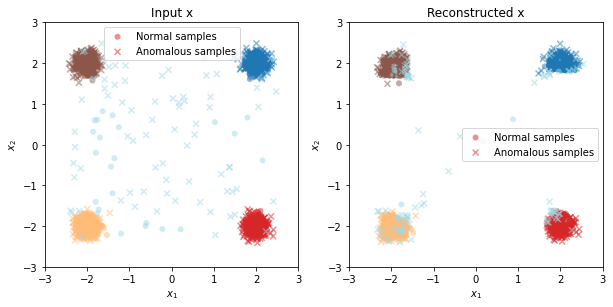

In [29]:
##  reconstructed x
fig_mx, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
ax[0].scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[0].scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[0].set_xlabel('$x_1$'); ax[0].set_ylabel('$x_2$')
ax[0].axis('on')
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].legend()
ax[0].set_title("Input x")

ax[1].scatter(rmx[idx_inliers, 0], rmx[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[1].scatter(rmx[idx_outliers, 0], rmx[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel('$x_1$'); ax[1].set_ylabel('$x_2$')
ax[1].axis('on')
ax[1].legend()
ax[1].set_title("Reconstructed x")
plt.savefig(result_dir + 'reconstruct_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

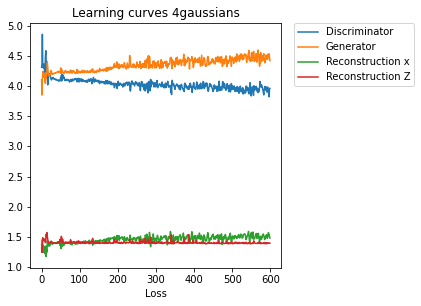

In [30]:
## learning curves
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction x")
ax.plot(np.array(FG)[:,2], label="Reconstruction Z")
plt.xlabel('Iteration')
plt.xlabel('Loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
ax.set_title("Learning curves {}".format(DATASET))
plt.savefig(result_dir + 'learning_curves_{}.png'.format(DATASET), bbox_inches='tight')
plt.show()